# HOKA Trilogy Run Asia 2024

For context, the HOKA Trilogy Run Asia is a series of races held in many different cities around the Philippines and each leg has an ever increasing distance from 16k, 21k and 32k. The National Finals is a full marathon and is help at Manila as a culmination of all the runners efforts. Of course there are shorter distances of 5k, 10k and 21k in the different legs but only runners who completed the longest distances in each leg is eligible for the full 42k. 

I was lucky enough to have been able to finish all legs and run at the National Finals albeit the build up towards it was less than ideal. Regardless, it was still a fun event and I was curious enough to know how most of the runners faired in their journey to the marathon.

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import requests
import numpy as np
import warnings
warnings.filterwarnings('ignore', category=Warning)

# Base URL for fetching race results
base_url = "https://results.raceroster.com/v2/api/result-events/{}/sub-events/{}/results?start={}&limit=1000&locale=en-US"

# Optimized race_list dictionary (Grouped by City)
race_list = {
    "Manila": {
        "eventId": "73132",
        "races": {
            "16k": "193987",
            "21k": "201025",
            "32k": "207624"
        }
    },
    "Iloilo-Bacolod": {
        "eventId": "73281",
        "races": {
            "16k": "200756",
            "21k": "206891",
            "32k": "215761"
        }
    },
    "Baguio": {
        "eventId": "73218",
        "races": {
            "16k": "196797",
            "21k": "205293",
            "32k": "217815"
        }
    },
    "Cebu": {
        "eventId": "73278",
        "races": {
            "16k": "194448",
            "21k": "202195",
            "32k": "208879"
        }
    },
    "Cagayan de Oro": {
        "eventId": "73282",
        "races": {
            "16k": "198168",
            "21k": "212292",
            "32k": "217259"
        }
    },
    "Davao": {
        "eventId": "73284",
        "races": {
            "16k": "203060",
            "21k": "209473",
            "32k": "216533"
        }
    },
    "National Finals":{
        "eventId": "81614",
            "races":{
                "42k":"219947"
        }
    }
}

# Define the race order
race_distances = ["16k", "21k", "32k","42k"]

# Dictionary to store separate DataFrames for each distance
race_dfs = {}

# Loop through distances first (16k → 21k → 32k), then cities
for race in race_distances:
    df_race = pd.DataFrame()  # Temporary DataFrame for the current distance
    
    for city, details in race_list.items():
        event_id = details["eventId"]
        
        # Skip if this city does not have the current race distance
        if race not in details["races"]:
            continue  

        race_id = details["races"][race]  # Get the race ID
        start = 0
        race_data = []  # Use a list instead of DataFrame for efficiency

        while True:
            # Fetch data from API
            response = requests.get(base_url.format(event_id, race_id, start))
            data = response.json().get('data', [])

            if not data:
                break  # Stop if no more data

            race_data.extend(data)  # Append new data to list
            start += 1000  # Increase offset

        if race_data:
            # Convert list of dicts into DataFrame efficiently
            race_df = pd.DataFrame.from_records(race_data)[['name', 'genderSexId', 'chipTime', 'division', 'overallPace']]

            # ✅ Add city column
            race_df["city"] = city

            # removing runners with no pace
            race_df = race_df[race_df['overallPace']!='']

            # ✅ Rename columns to include race distance
            race_df.rename(columns={
                'chipTime': f'chipTime_{race}',
                'overallPace': f'overallPace_{race}'
            }, inplace=True)

            # ✅ Drop "race" column before merging to prevent conflicts
            race_df.drop(columns=["race"], inplace=True, errors="ignore")

            # ✅ Merge with the current race DataFrame
            if df_race.empty:
                df_race = race_df
            else:
                df_race = pd.concat([df_race, race_df], ignore_index=True)

    # ✅ Store DataFrame for the current race
    race_dfs[race] = df_race

# ✅ Assign DataFrames to variables
df_16k = race_dfs.get("16k", pd.DataFrame())
df_21k = race_dfs.get("21k", pd.DataFrame())
df_32k = race_dfs.get("32k", pd.DataFrame())
df_42k = race_dfs.get("42k", pd.DataFrame())

# ✅ Merge them using left joins (16k → 21k → 32k)
df_final = df_16k.merge(df_21k.drop(columns = 'division'), on=['name', 'genderSexId','city'], how='left', suffixes=('', '_21k'))
df_final = df_final.merge(df_32k.drop(columns = 'division'), on=['name', 'genderSexId','city'], how='left', suffixes=('', '_32k'))
df_final = df_final.merge(df_42k.drop(columns = 'division'), on=['name', 'genderSexId'], how ='left', suffixes=('','_42k'))

# ✅ Drop duplicate columns caused by merging (if any)
df_final = df_final.loc[:, ~df_final.columns.duplicated()]
df_final = df_final.drop(columns = 'city_42k')

# ✅ Drop any remaining duplicate rows
df_final.drop_duplicates(inplace=True)

# Display Final Merged DataFrame
df_final = df_final[~df_final['name'].str.contains('Verification')]
df_final = df_final[~((df_final['chipTime_32k'].notnull())&(df_final['chipTime_21k'].isnull()))]
df_final = df_final[~((df_final['chipTime_42k'].notnull())&(df_final['chipTime_32k'].isnull()))]
df_final = df_final.sort_values(by = ['chipTime_42k','chipTime_32k','chipTime_21k','chipTime_16k']).groupby('name').head(1) # grouping by the runner
df_final = df_final.reset_index().rename(columns={"index": "id", 'genderSexId':'gender'}) # renaming columns 
df_final = df_final.drop(columns = 'name') # dropping names of runners for privacy 

time_cols = ['overallPace_16k','overallPace_21k','overallPace_32k','overallPace_42k']
df_final[time_cols] = df_final[time_cols].apply(pd.to_timedelta)
df_final

,id,gender,chipTime_16k,division,overallPace_16k,city,chipTime_21k,overallPace_21k,chipTime_32k,overallPace_32k,chipTime_42k,overallPace_42k
0,2,Male,53:28,25-29 Male,0 days 00:03:21,Manila,1:14:08,0 days 00:03:32,1:54:15,0 days 00:03:34,2:54:25,0 days 00:04:09
1,532,Male,1:35:53,30-34 Male,0 days 00:06:00,Manila,2:29:14,0 days 00:07:06,4:06:05,0 days 00:07:41,3:09:15,0 days 00:04:30
2,9,Male,1:04:40,40-44 Male,0 days 00:04:03,Manila,1:29:17,0 days 00:04:15,2:22:06,0 days 00:04:26,3:12:46,0 days 00:04:35
3,10,Male,1:05:28,25-29 Male,0 days 00:04:06,Manila,1:28:43,0 days 00:04:13,2:23:22,0 days 00:04:29,3:15:21,0 days 00:04:39
4,4137,Male,1:13:01,45-49 Male,0 days 00:04:34,Baguio,1:34:15,0 days 00:04:29,2:31:14,0 days 00:04:44,3:16:26,0 days 00:04:41
...,...,...,...,...,...,...,...,...,...,...,...,...
5880,4785,Male,53:09,18-24 Male,0 days 00:03:19,Cebu,NaN,NaT,NaN,NaT,NaN,NaT
5881,4786,Male,53:11,25-29 Male,0 days 00:03:19,Cebu,NaN,NaT,NaN,NaT,NaN,NaT
5882,4787,Male,55:54,30-34 Male,0 days 00:03:30,Cebu,NaN,NaT,NaN,NaT,NaN,NaT
5883,4788,Male,57:17,25-29 Male,0 days 00:03:35,Cebu,NaN,NaT,NaN,NaT,NaN,NaT


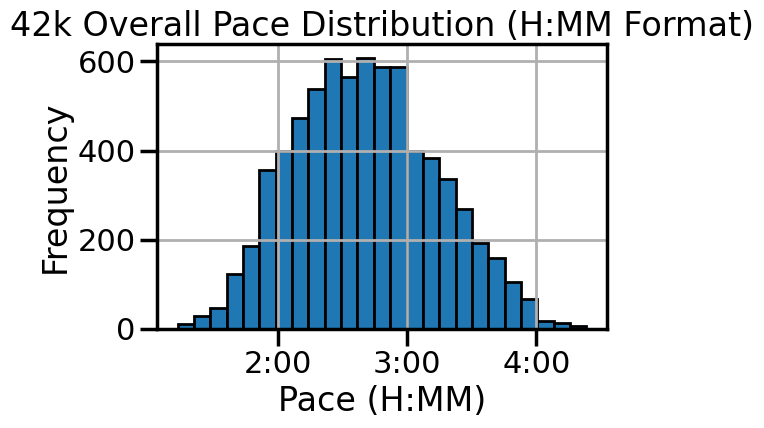

In [14]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

df = df_21k.copy()
df['chipTime_21k'] = pd.to_timedelta(df['chipTime_21k'],errors='coerce')

# Convert timedelta to total hours as float (e.g. 6.9833 for 6h 59m)
df['pace_hours'] = df['chipTime_21k'].dt.total_seconds() / 3600

# Formatter: convert float hours to H:MM string
def format_h_mm(x, _):
    hours = int(x)
    minutes = int(round((x - hours) * 60))
    return f"{hours}:{minutes:02d}"

# Plot histogram
ax = df['pace_hours'].plot(
    kind='hist',
    bins=25,
    edgecolor='black',
    title='42k Overall Pace Distribution (H:MM Format)'
)

ax.set_xlabel('Pace (H:MM)')
ax.set_ylabel('Frequency')
ax.xaxis.set_major_formatter(ticker.FuncFormatter(format_h_mm))

plt.grid(True)
plt.tight_layout()
plt.show()


# About the dataset
I mostly scraped the data from the website's race result which can be found here: https://www.trilogyrunasia.com/results-and-photos

The mechanics of the run series allows runners to run in any city as long as they complete each leg at the longest distance but for the purposes of  this analysis, I only considered runners who completed all of their legs in a one city.

In [15]:
df = df_final.groupby('city').agg(total_runners = ('id','count'), 
                        pace16k = ('overallPace_16k','mean'),
                      pace21k = ('overallPace_21k','mean'),
                      pace32k = ('overallPace_32k','mean'),
                      pace42k = ('overallPace_42k','mean'),
                       count16k = ('overallPace_16k','count'),
                      count21k = ('overallPace_21k','count'),
                      count32k = ('overallPace_32k','count'),
                      count42k = ('overallPace_42k','count')).reset_index()
df['completion_16k'] = (df['count16k'] /df['total_runners'] * 100).round(2)
df['completion_21k'] = (df['count21k'] /df['total_runners'] * 100).round(2)
df['completion_32k'] = (df['count32k'] /df['total_runners'] * 100).round(2)
df['completion_42k'] = (df['count42k'] /df['total_runners'] * 100).round(2)
df['dist'] = df['count42k'] / df['count42k'].sum() * 100
df.sort_values('pace42k')

,city,total_runners,pace16k,pace21k,pace32k,pace42k,count16k,count21k,count32k,count42k,completion_16k,completion_21k,completion_32k,completion_42k,dist
1,Cagayan de Oro,434,0 days 00:07:04.375576036,0 days 00:07:00.411347517,0 days 00:07:29.337837837,0 days 00:07:38.676470588,434,282,222,68,100.0,64.98,51.15,15.67,5.037037
0,Baguio,437,0 days 00:07:54.700228832,0 days 00:07:39.194244604,0 days 00:07:57.181818181,0 days 00:08:09.694444444,437,139,66,36,100.0,31.81,15.10,8.24,2.666667
4,Iloilo-Bacolod,410,0 days 00:07:21.953658536,0 days 00:06:50.362385321,0 days 00:07:16.224358974,0 days 00:08:15.354838709,410,218,156,62,100.0,53.17,38.05,15.12,4.592593
2,Cebu,548,0 days 00:07:10.281021897,0 days 00:07:30.449230769,0 days 00:07:58.212996389,0 days 00:08:26.946236559,548,325,277,93,100.0,59.31,50.55,16.97,6.888889
5,Manila,3366,0 days 00:07:30.913844325,0 days 00:07:54.183781401,0 days 00:08:15.216743119,0 days 00:08:34.106666666,3366,2269,1744,900,100.0,67.41,51.81,26.74,66.666667
3,Davao,690,0 days 00:07:24.228985507,0 days 00:07:23.640657084,0 days 00:07:55.586448598,0 days 00:08:34.293193717,690,487,428,191,100.0,70.58,62.03,27.68,14.148148


# City Breakdown
The dataframe above will be the main dataset to be used as I was only interested in seeing this from a city level perspective. There are lots of other ways to dissect the data but I just wanted to keep it short and simple for each city.

Just a few things to note, unsurprisingly, the most number of runners come from Manila as it is the capital with 66% of the total marathon runners, with Davao being second at 14. Baguio has the least representation with just a total of 36 runners present.

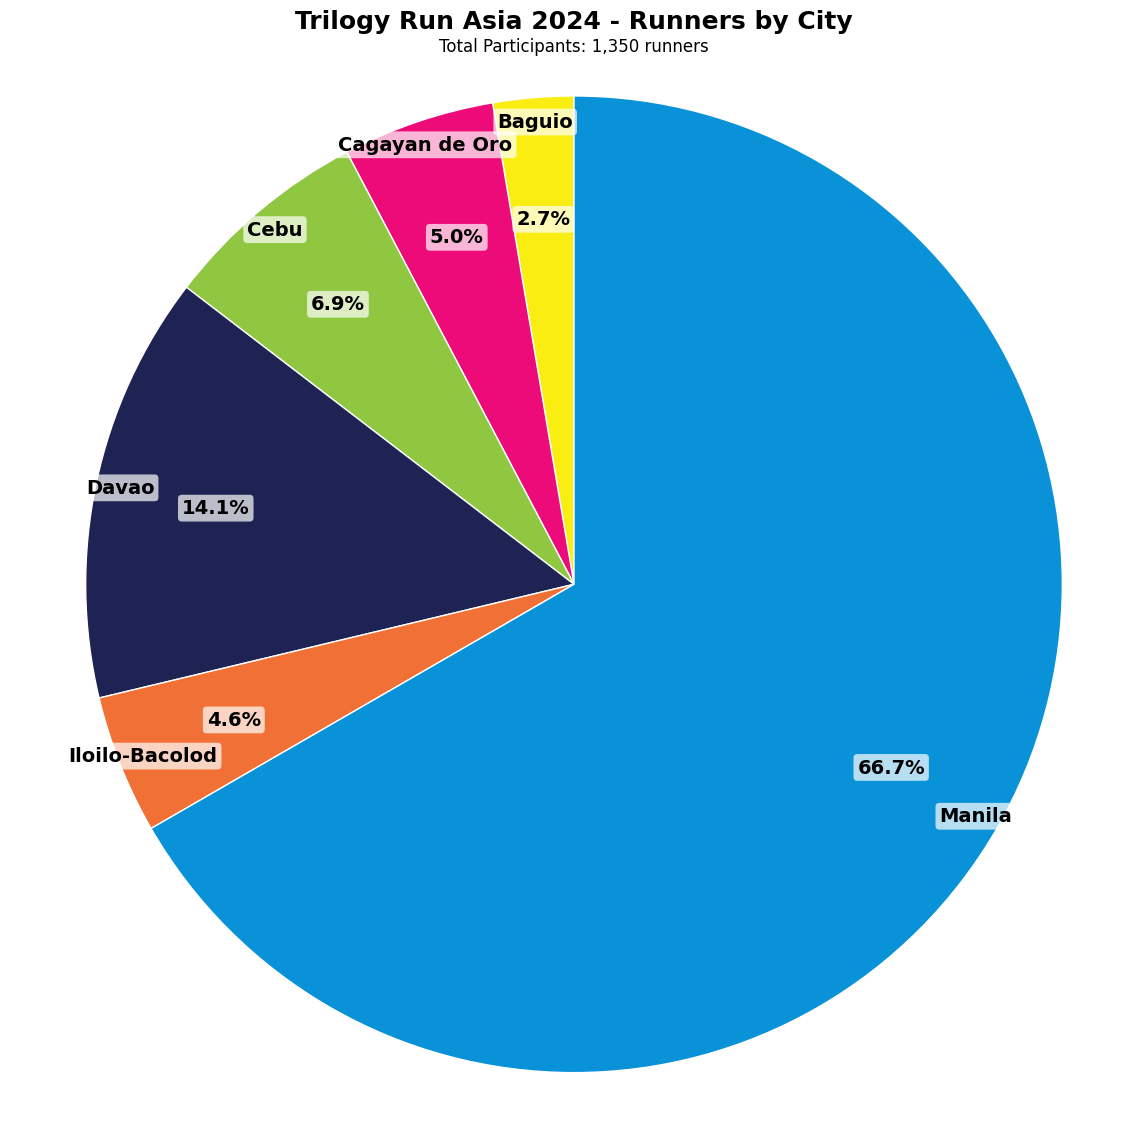

In [16]:
# 🔹 USER-CONTROLLED OPTIONS 🔹
SEABORN_STYLE = "whitegrid"  # Options: "darkgrid", "whitegrid", "dark", "white", "ticks"
MATPLOTLIB_STYLE = "default"  # Options: "ggplot", "fivethirtyeight", "grayscale", etc.
SEABORN_CONTEXT = "poster"  # Options: "paper", "notebook", "talk", "poster"

# 🎨 Fixed Colors Per City
city_colors = {
    "Baguio": "#FAED12",          # Bright Blue
    "Cagayan de Oro": "#ED0B79",  # Vivid Pink
    "Cebu": "#8FC740",            # Fresh Green
    "Davao": "#1F2353",           # Deep Navy Blue
    "Iloilo-Bacolod": "#F17036",  # Warm Orange
    "Manila": "#0992D8"           # Bright Yellow
}

# 🛠 APPLY STYLES & CONTEXT
sns.set_style(SEABORN_STYLE)  
plt.style.use(MATPLOTLIB_STYLE)  
sns.set_context(SEABORN_CONTEXT)  

plt.figure(figsize=(12, 12))

# Create pie chart with edge labels
plt.pie(
    df['dist'],
    labels=None,  # No labels inside wedges
    colors=[city_colors[city] for city in df['city']],
    autopct=lambda pct: f'{pct:.1f}%',
    pctdistance=0.75,  # Positions percentages near edge
    startangle=90,
    wedgeprops={'linewidth': 1, 'edgecolor': 'white'},
    textprops={
        'fontsize': 14,
        'fontweight': 'bold',
        'color': 'black',
        'bbox': dict(boxstyle='round,pad=0.2', fc='white', ec='none', alpha=0.7)
    }
)

# Add city names as labels outside the pie
plt.gca().set_label('')
for i, (city, pct) in enumerate(zip(df['city'], df['dist']/df['dist'].sum()*100)):
    angle = 90 + 360 * (df['dist'].cumsum()[i] - df['dist'][i]/2) / df['dist'].sum()
    x = 0.95 * np.cos(np.radians(angle))
    y = 0.95 * np.sin(np.radians(angle))
    plt.text(x, y, city, 
             ha='center', va='center',
             fontsize=14,
             fontweight='bold',
             bbox=dict(boxstyle='round,pad=0.2', 
                      fc='white', 
                      ec='none', 
                      alpha=0.7))

# Main title (positioned higher)
plt.title("Trilogy Run Asia 2024 - Runners by City", 
          fontsize=18, fontweight="bold", pad=16)  # Reduced pad from 20 to 12

# Subtitle with total runners (positioned below main title)
plt.text(0.5, .923,  # Adjusted y-position to be below main title
         f"Total Participants: {df['count42k'].sum():,} runners", 
         ha='center', 
         va='center', 
         fontsize=12,
         transform=plt.gcf().transFigure)

plt.axis('equal')
plt.tight_layout()
plt.show()

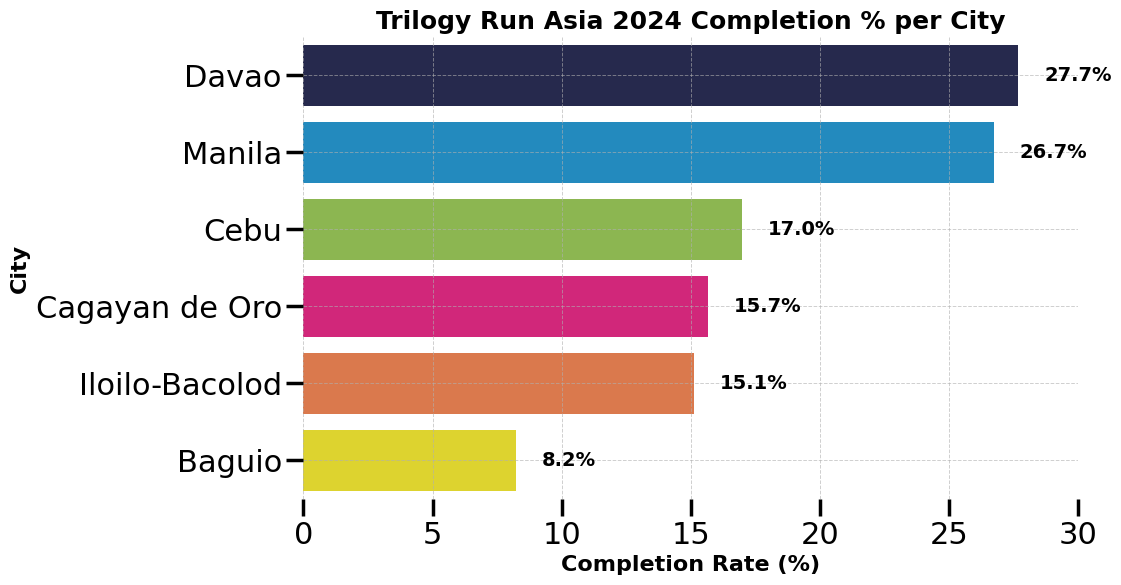

In [17]:
# 📊 Create the bar chart
plt.figure(figsize=(10, 6))
ax = sns.barplot(
    data=df, 
    x="completion_42k", 
    y="city", 
    palette=city_colors, 
    order=df.sort_values("completion_42k", ascending=False)["city"],
    edgecolor="none"  
)

# 🎯 Titles & Labels
plt.title("Trilogy Run Asia 2024 Completion % per City", fontsize=18, fontweight="bold", color="black")
plt.xlabel("Completion Rate (%)", fontsize=16, fontweight="bold", color="black")
plt.ylabel("City", fontsize=16, fontweight="bold", color="black")
plt.xlim(0, 30)

# 🔢 Add larger values at the end of each bar
for index, value in enumerate(df.sort_values("completion_42k", ascending=False)["completion_42k"]):
    ax.text(value + 1, index, f"{value:.1f}%", fontsize=14, color="black", va="center", fontweight="bold")  # ⬆ Increased font size to 14

# 🖌 Grid Styling
ax.grid(True, linestyle="--", linewidth=0.7, alpha=0.6)

# 🚀 Remove spines for a cleaner look
sns.despine(left=True, bottom=True)

# 📌 Show Plot
plt.show()


# Completion Rate per City
Davao has the highest completion rate with almost 28% of the runners finishing the whole series. Manila is also close at almost 27% and Baguio has the lowest at 8.2%.

I would assume Baguio runners would have a higher completion rate of the series seeing as they are the only ones that don't require a flight to Manila. Perhaps the bus ride to Manila is not worth it enough for them to finish the series.

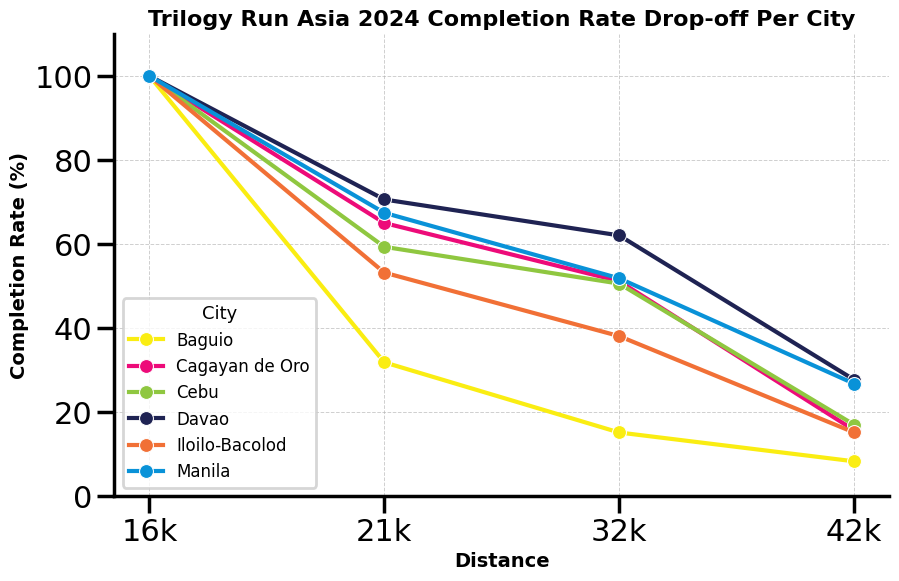

In [18]:
# 🔄 Melt DataFrame to long format
df_melted = df[['city','completion_16k','completion_21k','completion_32k','completion_42k']].melt(id_vars="city", var_name="distance", value_name="completion_rate")
df_melted["distance"] = df_melted["distance"].str.replace("completion_", "")
df_melted["distance"] = pd.Categorical(df_melted["distance"], categories=["16k", "21k", "32k", "42k"], ordered=True)

# 📊 Create the line plot
plt.figure(figsize=(10, 6))
ax = sns.lineplot(
    data=df_melted, 
    x="distance", 
    y="completion_rate", 
    hue="city", 
    marker="o", 
    linewidth=3,  
    markersize=10,  
    palette=city_colors  
)

# 🎯 Titles & Labels
plt.title("Trilogy Run Asia 2024 Completion Rate Drop-off Per City", fontsize=16, fontweight="bold", color="black")
plt.xlabel("Distance", fontsize=14, fontweight="bold", color="black")
plt.ylabel("Completion Rate (%)", fontsize=14, fontweight="bold", color="black")
plt.ylim(0, 110)

# 🎨 Customize Legend
legend = plt.legend(title="City", fontsize=12, title_fontsize=13, loc="lower left", frameon=True)
plt.setp(legend.get_texts(), color="black")  

# 🖌 Grid Styling
ax.grid(True, linestyle="--", linewidth=0.7, alpha=0.6)

# 🚀 Clean up chart aesthetics
sns.despine()

# 📌 Show Plot
plt.show()

## Further Breakdown

We can see here even still that Baguio runners weren't really keen on finishing the series as by Leg 2, we can see that there was already a significant drop off of runners 31% compared to other cities where they were still around 60%-70% participation for the Leg 2.

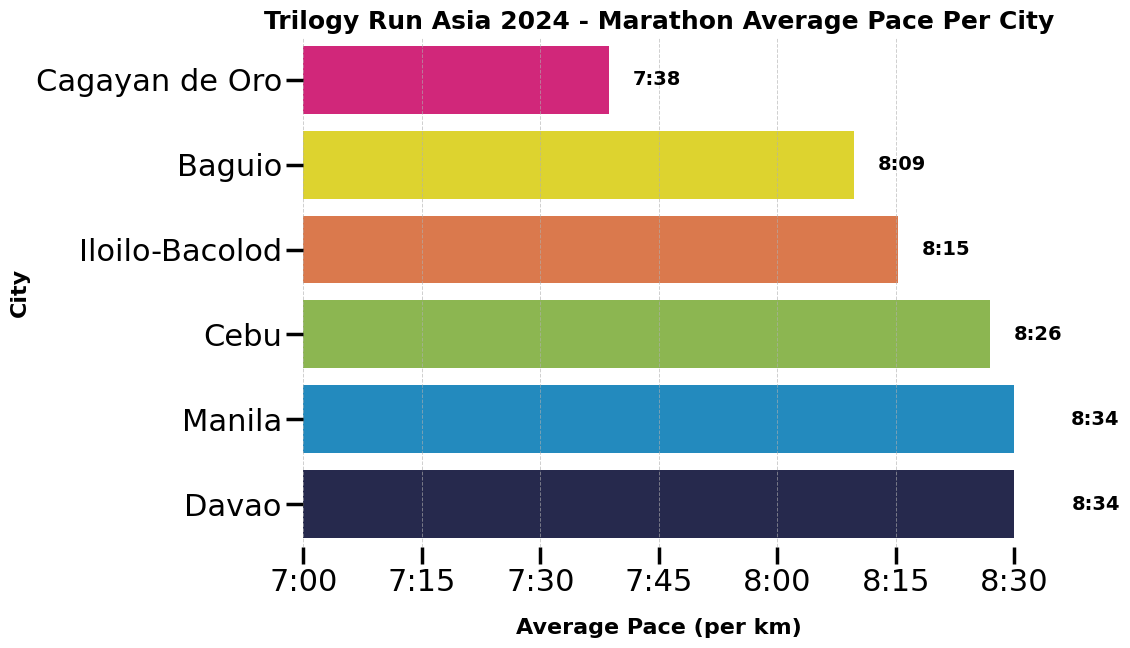

In [19]:
# 🔄 Convert timedelta pace to total seconds
df["pace42k_seconds"] = df["pace42k"].dt.total_seconds()

# 📊 Create the horizontal bar chart
plt.figure(figsize=(12, 7))  # Slightly wider for better label spacing
ax = sns.barplot(
    data=df, 
    x="pace42k_seconds",  
    y="city", 
    palette=city_colors, 
    order=df.sort_values("pace42k_seconds", ascending=True)["city"],  
    edgecolor="none"  
)

# 🎯 Titles & Labels
plt.title("Trilogy Run Asia 2024 - Marathon Average Pace Per City", fontsize=18, fontweight="bold", color="black")
plt.xlabel("Average Pace (per km)", fontsize=16, fontweight="bold", color="black", labelpad=15)
plt.ylabel("City", fontsize=16, fontweight="bold", color="black")

# ⏱ Set X-axis range and 15-second increments
min_pace = 420  # 7:00 in seconds
max_pace = 510  # 9:00 in seconds
plt.xlim(min_pace, max_pace)

# Create 15-second increments
x_ticks = np.arange(min_pace, max_pace + 15, 15)  # From 7:00 to 9:00 by 15s

# Format ticks as mm:ss
def format_mmss(x, pos):
    mins = int(x // 60)
    secs = int(x % 60)
    return f"{mins}:{secs:02d}"

ax.xaxis.set_major_formatter(ticker.FuncFormatter(format_mmss))
ax.set_xticks(x_ticks)  # Apply our 15-second increments

# 🔢 Add pace values at the end of each bar (in mm:ss format)
for index, value in enumerate(df.sort_values("pace42k_seconds", ascending=True)["pace42k_seconds"]):
    mins = int(value // 60)
    secs = int(value % 60)
    ax.text(value + 3, index, f"{mins}:{secs:02d}",  # Format as mm:ss
            fontsize=14, color="black", va="center", fontweight="bold")  

# 🖌 Grid Styling
ax.grid(True, linestyle="--", linewidth=0.7, alpha=0.6, axis='x')

# 🚀 Remove spines for a cleaner look
sns.despine(left=True, bottom=True)

# 📌 Show Plot
plt.tight_layout()
plt.show()

# Fastest City
Cagayan de Oro had the fastest marathon pace at 7:38 min/km, finishing in ~5h 22m.

Manila & Davao were the slowest at 8:34 min/km, finishing slightly over 6 hours.

Other cities fell in between, with Baguio (8:09), Iloilo-Bacolod (8:15), and Cebu (8:26) showing moderate pacing.

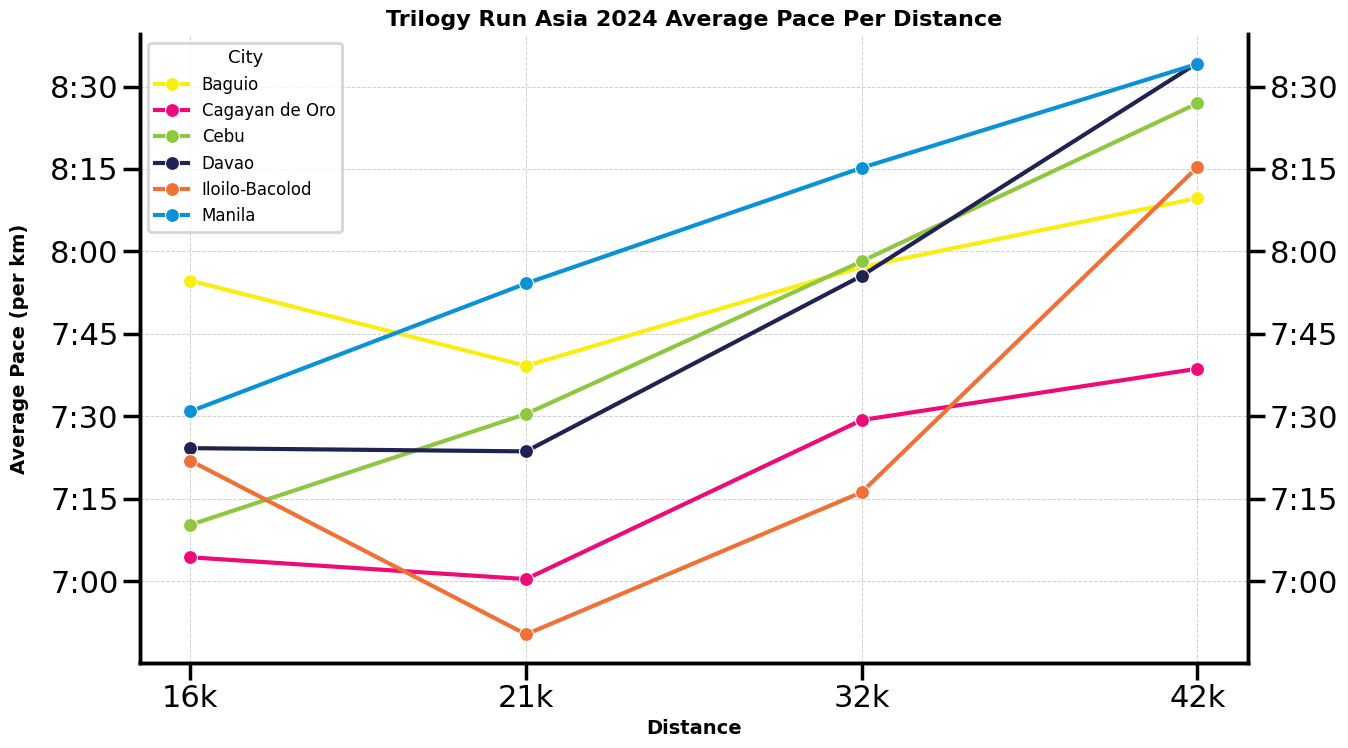

In [20]:
# 🔄 Melt DataFrame to long format
df_melted = df[['city','pace16k','pace21k','pace32k','pace42k']].melt(id_vars="city", var_name="distance", value_name="average_pace")
df_melted["distance"] = df_melted["distance"].str.replace("pace", "")
df_melted["distance"] = pd.Categorical(df_melted["distance"], categories=["16k", "21k", "32k", "42k"], ordered=True)

# 🔄 Convert Timedelta to Minutes
df_melted["average_pace"] = df_melted["average_pace"].dt.total_seconds() / 60  # Convert to minutes

# 📊 Create the line plot
plt.figure(figsize=(14, 8))
ax = sns.lineplot(
    data=df_melted, 
    x="distance", 
    y="average_pace", 
    hue="city", 
    marker="o", 
    linewidth=3,  
    markersize=10,  
    palette=city_colors  
)

# 🎯 Titles & Labels
plt.title("Trilogy Run Asia 2024 Average Pace Per Distance", fontsize=16, fontweight="bold", color="black")
plt.xlabel("Distance", fontsize=14, fontweight="bold", color="black")

# ✅ Move y-axis title to the right
ax.yaxis.set_label_position("left")
plt.ylabel("Average Pace (per km)", fontsize=14, fontweight="bold", color="black", labelpad=15)

# ✅ Add duplicate y-axis on the left
ax2 = ax.twinx()
ax2.set_ylim(ax.get_ylim())  # Match the primary y-axis limits

# 🔢 Format both y-axes as mm:ss
def format_minutes(x, pos):
    mins = int(x)
    secs = int((x - mins) * 60)
    return f"{mins}:{secs:02d}"

ax.yaxis.set_major_formatter(ticker.FuncFormatter(format_minutes))
ax2.yaxis.set_major_formatter(ticker.FuncFormatter(format_minutes))

# 🖌 Grid Styling
ax.grid(True, linestyle="--", linewidth=0.7, alpha=0.6)

# 🎨 Customize Legend (inside, upper right)
legend = ax.legend(title="City", fontsize=12, title_fontsize=13, loc="upper left", frameon=True)
plt.setp(legend.get_texts(), color="black")  

# 🚀 Clean up chart aesthetics
sns.despine(left=False, right=False, top=True)  # Keep both left and right spines

# 📌 Show Plot
plt.tight_layout()
plt.show()

## Progression on each Leg
Cagayan de Oro maintained a steady pace, consistently below 7:45 min/km.

Iloilo-Bacolod was faster in the 21k and 32k but dropped significantly in the 42k, slowing by a full minute.

Manila & Davao struggled with endurance, showing a steady decline in pace.

Cebu slowed down gradually but managed better than Iloilo-Bacolod.

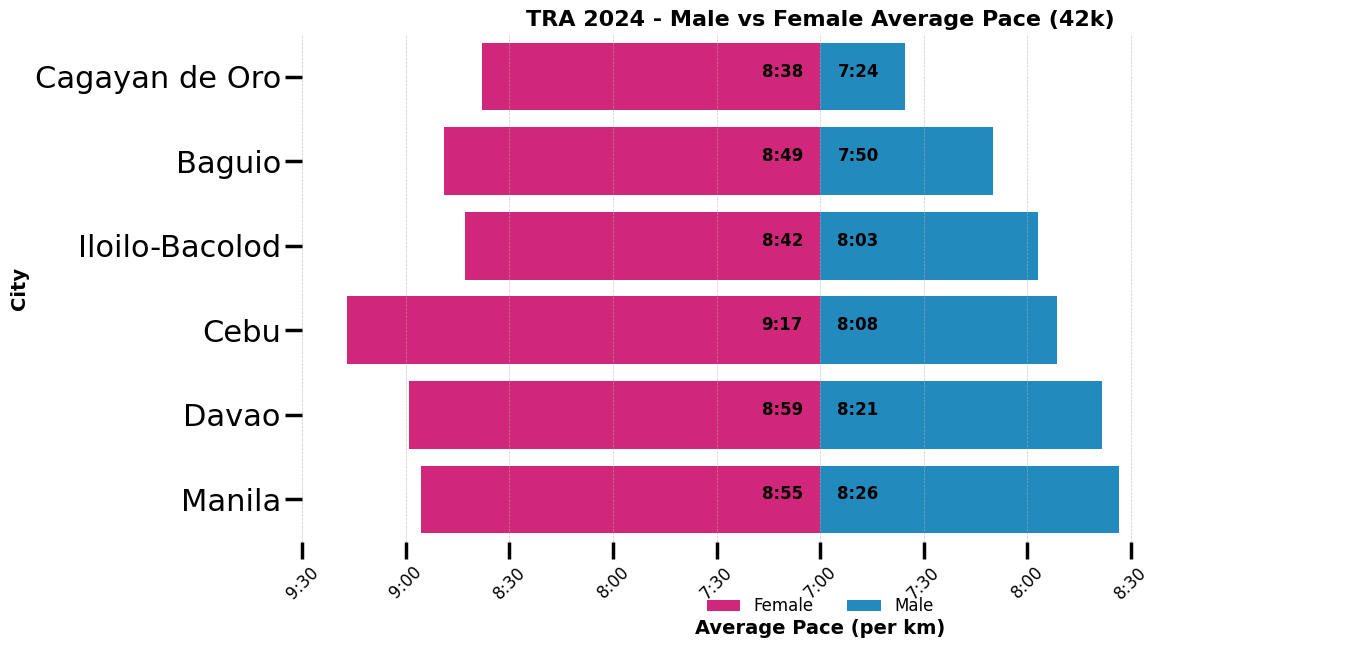

In [21]:
# Group by gender and city, then compute mean pace
df = df_final.groupby(['gender', 'city'])['overallPace_42k'].mean().reset_index()
df = df[df['gender'] != 'Unknown']

# Convert pace times to total seconds and store original values for labels
df["overallPace_seconds"] = pd.to_timedelta(df["overallPace_42k"]).dt.total_seconds()
df["shifted_pace"] = df["overallPace_seconds"] - 420  # Shift so 7:00 is center

# Pivot data for plotting (using shifted values)
df_pivot = df.pivot(index="city", columns="gender", values="shifted_pace").reset_index()

# --- CUSTOM CITY ORDERING STARTS HERE ---
# Define the desired city order
custom_city_order = ['Cagayan de Oro','Baguio',"Iloilo-Bacolod", "Cebu","Davao","Manila"]

# Convert 'city' to categorical and sort
df_pivot['city'] = pd.Categorical(
    df_pivot['city'], 
    categories=custom_city_order, 
    ordered=True
)
df_pivot = df_pivot.sort_values('city').reset_index(drop=True)
# --- CUSTOM CITY ORDERING ENDS HERE ---

# Store original pace values for labels
original_paces = df.pivot(index="city", columns="gender", values="overallPace_seconds").reset_index()

# Convert Female paces to negative for diverging bar chart
df_pivot["Female"] = -df_pivot["Female"]

# Set colors
male_color = "#0992D8"   # Blue
female_color = "#ED0B79" # Pink

# Adjust figure size and layout
plt.figure(figsize=(14, 7))  # Wider for better spacing

# Female Bars (Left Side)
sns.barplot(y=df_pivot["city"], x=df_pivot["Female"], color=female_color, label="Female", edgecolor="none")

# Male Bars (Right Side)
sns.barplot(y=df_pivot["city"], x=df_pivot["Male"], color=male_color, label="Male", edgecolor="none")

# Titles & Labels
plt.title("TRA 2024 - Male vs Female Average Pace (42k)", fontsize=16, fontweight="bold")
plt.xlabel("Average Pace (per km)", fontsize=14, fontweight="bold", labelpad=12)
plt.ylabel("City", fontsize=14, fontweight="bold")

# Define X-Axis Range (From 9:30 - 7:00 - 9:30)
x_min, x_max = -150, 150  # More spacing for clarity
x_ticks = [-150, -120, -90, -60, -30, 0, 30, 60, 90]
x_labels = ["9:30", "9:00", "8:30", "8:00", "7:30", "7:00", "7:30", "8:00", "8:30"]

plt.xticks(ticks=x_ticks, labels=x_labels, fontsize=12, rotation=45)
plt.xlim(x_min, x_max)

# Add CORRECT pace values at the BASE of each bar (aligned near x=0)
for index, row in df_pivot.iterrows():
    city = row["city"]
    
    # Get original pace values (not shifted)
    male_pace_seconds = original_paces.loc[original_paces["city"] == city, "Male"].values[0]
    female_pace_seconds = original_paces.loc[original_paces["city"] == city, "Female"].values[0]
    
    # Format as mm:ss
    male_pace = f"{int(male_pace_seconds // 60)}:{int(male_pace_seconds % 60):02d}"
    female_pace = f"{int(female_pace_seconds // 60)}:{int(female_pace_seconds % 60):02d}"

    # Female Labels - Placed at the base (near x=0)
    plt.text(0 - 5, index, female_pace, ha="right", fontsize=12, color="black", fontweight="bold")
    
    # Male Labels - Placed at the base (near x=0)
    plt.text(0 + 5, index, male_pace, ha="left", fontsize=12, color="black", fontweight="bold")

# Adjust legend placement
plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.08), ncol=2, frameon=False, fontsize=12)

# Improve grid and remove spines
sns.despine(left=True, bottom=True)
plt.grid(axis="x", linestyle="--", linewidth=0.5, alpha=0.7)

plt.tight_layout()  # Prevent label cutoff
plt.show()

# TRA 2024: Gender Pace Analysis
Key Findings:

Men faster than women in all cities (expected)

Cagayan de Oro dominates:

Fastest male (7:24/km) and female (8:38/km) runners

Female pace leads by +0:48 over Manila (8:26/km)

Baguio excels at altitude (male: 7:50/km, female: 8:49/km)

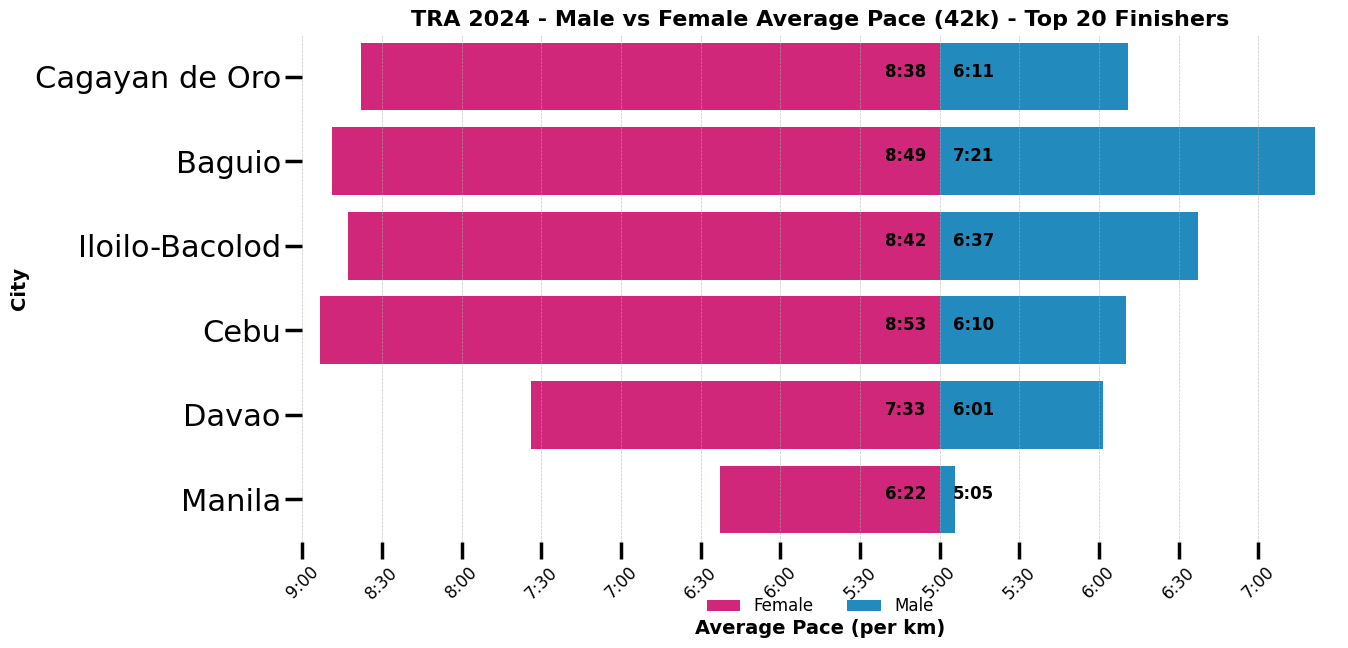

In [22]:
# Group by gender and city, then compute mean pace
df = df_final.groupby(['city','gender']).head(20).groupby(['gender', 'city'])['overallPace_42k'].mean().reset_index()
df = df[df['gender'] != 'Unknown']

# Convert pace times to total seconds and store original values for labels
df["overallPace_seconds"] = pd.to_timedelta(df["overallPace_42k"]).dt.total_seconds()
df["shifted_pace"] = df["overallPace_seconds"] - 300  # Shift so 7:00 is center

# Pivot data for plotting (using shifted values)
df_pivot = df.pivot(index="city", columns="gender", values="shifted_pace").reset_index()

# --- CUSTOM CITY ORDERING STARTS HERE ---
# Define the desired city order
custom_city_order = ['Cagayan de Oro','Baguio',"Iloilo-Bacolod", "Cebu","Davao","Manila"]

# Convert 'city' to categorical and sort
df_pivot['city'] = pd.Categorical(
    df_pivot['city'], 
    categories=custom_city_order, 
    ordered=True
)
df_pivot = df_pivot.sort_values('city').reset_index(drop=True)
# --- CUSTOM CITY ORDERING ENDS HERE ---

# Store original pace values for labels
original_paces = df.pivot(index="city", columns="gender", values="overallPace_seconds").reset_index()

# Convert Female paces to negative for diverging bar chart
df_pivot["Female"] = -df_pivot["Female"]

# Set colors
male_color = "#0992D8"   # Blue
female_color = "#ED0B79" # Pink

# Adjust figure size and layout
plt.figure(figsize=(14, 7))  # Wider for better spacing

# Female Bars (Left Side)
sns.barplot(y=df_pivot["city"], x=df_pivot["Female"], color=female_color, label="Female", edgecolor="none")

# Male Bars (Right Side)
sns.barplot(y=df_pivot["city"], x=df_pivot["Male"], color=male_color, label="Male", edgecolor="none")

# Titles & Labels
plt.title("TRA 2024 - Male vs Female Average Pace (42k) - Top 20 Finishers", fontsize=16, fontweight="bold")
plt.xlabel("Average Pace (per km)", fontsize=14, fontweight="bold", labelpad=12)
plt.ylabel("City", fontsize=14, fontweight="bold")

# Define X-Axis Range (From 9:30 - 7:00 - 9:30)
x_min, x_max = -240, 150  # More spacing for clarity
x_ticks = [-240,-210,-180,-150, -120, -90, -60, -30, 0, 30, 60, 90, 120]
x_labels = ['9:00','8:30','8:00',"7:30", "7:00", "6:30", "6:00", "5:30", "5:00", "5:30", "6:00", "6:30", '7:00']

plt.xticks(ticks=x_ticks, labels=x_labels, fontsize=12, rotation=45)
plt.xlim(x_min, x_max)

# Add CORRECT pace values at the BASE of each bar (aligned near x=0)
for index, row in df_pivot.iterrows():
    city = row["city"]
    
    # Get original pace values (not shifted)
    male_pace_seconds = original_paces.loc[original_paces["city"] == city, "Male"].values[0]
    female_pace_seconds = original_paces.loc[original_paces["city"] == city, "Female"].values[0]
    
    # Format as mm:ss
    male_pace = f"{int(male_pace_seconds // 60)}:{int(male_pace_seconds % 60):02d}"
    female_pace = f"{int(female_pace_seconds // 60)}:{int(female_pace_seconds % 60):02d}"

    # Female Labels - Placed at the base (near x=0)
    plt.text(0 - 5, index, female_pace, ha="right", fontsize=12, color="black", fontweight="bold")
    
    # Male Labels - Placed at the base (near x=0)
    plt.text(0 + 5, index, male_pace, ha="left", fontsize=12, color="black", fontweight="bold")

# Adjust legend placement
plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.08), ncol=2, frameon=False, fontsize=12)

# Improve grid and remove spines
sns.despine(left=True, bottom=True)
plt.grid(axis="x", linestyle="--", linewidth=0.5, alpha=0.7)

plt.tight_layout()  # Prevent label cutoff
plt.show()

## Elite Finishers: Manila Dominates the Podium
When we examine the top 20 finishers across all cities, Manila's runners stand in a class of their own. The capital's elite male runners clocked an astonishing average pace of 5:05 min/km - that's a marathon finish time hovering around 3 hours and 30 minutes. Not to be outdone, Manila's female elites were equally impressive with a 6:22 min/km pace (approximately 4 hours 28 minutes).

What's truly remarkable is the performance gap between Manila's female runners and other cities. Outside of Davao (6:45 min/km), every other city trailed Manila by more than two full minutes per kilometer. This stark difference highlights an important reality: while Manila benefits from superior running infrastructure, safety, and training facilities as the national capital, other cities clearly need more support systems to help their female athletes compete at the highest levels.

The data suggests that access to proper training environments makes a measurable difference. Manila's runners - both male and female - demonstrate what's possible when athletes have access to:

Safe running routes

Quality coaching

Regular competitions

Supportive running communities

While the natural talent exists across all cities, closing this performance gap will require targeted investments in running infrastructure outside the capital. Davao's relatively strong showing proves it's possible to compete with Manila given the right conditions.

# Machine Learning Predicting Manila Runners Pace

In [23]:
train_df = df_final[(df_final['chipTime_42k'].notnull())]


In [24]:
train_df = train_df[['city','gender','division','chipTime_16k','chipTime_21k','chipTime_32k','chipTime_42k']]
train_df['division'] = train_df['division'].replace('70+ Male', '70-74 Male')
train_df = train_df.reset_index(drop=True).reset_index().rename(columns={'index': 'runner_id'})
train_df

,runner_id,city,gender,division,chipTime_16k,chipTime_21k,chipTime_32k,chipTime_42k
0,0,Manila,Male,25-29 Male,53:28,1:14:08,1:54:15,2:54:25
1,1,Manila,Male,30-34 Male,1:35:53,2:29:14,4:06:05,3:09:15
2,2,Manila,Male,40-44 Male,1:04:40,1:29:17,2:22:06,3:12:46
3,3,Manila,Male,25-29 Male,1:05:28,1:28:43,2:23:22,3:15:21
4,4,Baguio,Male,45-49 Male,1:13:01,1:34:15,2:31:14,3:16:26
...,...,...,...,...,...,...,...,...
1345,1345,Manila,Male,30-34 Male,2:14:52,2:48:25,5:31:29,7:59:10
1346,1346,Manila,Male,30-34 Male,2:18:19,3:11:59,5:50:14,7:59:23
1347,1347,Manila,Female,25-29 Female,2:50:14,4:07:49,5:35:05,7:59:33
1348,1348,Cagayan de Oro,Female,25-29 Female,2:25:20,3:39:38,5:47:27,7:59:42


In [25]:
#website: https://raceroster.com/search?q=trilogy%20run%20asia&t=past

race_list = {
    "Manila": {

        "2025": {
            "16k": {"eventId": "85809", "raceId": "223772"},
            "21k": {"eventId": "87034", "raceId": "228307"},
            "32k": {"eventId": "87040", "raceId": "234242"}
        }
    }
}
# Define the race order
race_distances = ["16k", "21k", "32k"]
race_dfs = {}

for race in race_distances:
    df_race = pd.DataFrame()

    for city, years in race_list.items():
        for year, races in years.items():
            if race not in races:
                continue

            event_id = races[race]["eventId"]
            race_id = races[race]["raceId"]

            start = 0
            race_data = []

            while True:
                response = requests.get(base_url.format(event_id, race_id, start))
                data = response.json().get('data', [])
                if not data:
                    break
                race_data.extend(data)
                start += 1000

            if race_data:
                race_df = pd.DataFrame.from_records(race_data)[['name', 'genderSexId', 'chipTime', 'division', 'overallPace']]
                race_df["city"] = city
                #race_df["year"] = year
                race_df = race_df[race_df['overallPace'] != '']

                race_df.rename(columns={
                    'chipTime': f'chipTime_{race}',
                    'overallPace': f'overallPace_{race}'
                }, inplace=True)

                race_df.drop(columns=["race"], inplace=True, errors="ignore")

                df_race = pd.concat([df_race, race_df], ignore_index=True)

    race_dfs[race] = df_race
# ✅ Assign DataFrames to variables
df_16k = race_dfs.get("16k", pd.DataFrame())
df_21k = race_dfs.get("21k", pd.DataFrame())
df_32k = race_dfs.get("32k", pd.DataFrame())

# ✅ Merge them using left joins (16k → 21k → 32k)
df_final = df_16k.merge(df_21k.drop(columns = 'division'), on=['name', 'genderSexId','city'], how='left', suffixes=('', '_21k'))
df_final = df_final.merge(df_32k.drop(columns = 'division'), on=['name', 'genderSexId','city'], how='left', suffixes=('', '_32k'))
#df_final = df_final.merge(df_42k.drop(columns = 'division'), on=['name', 'genderSexId'], how ='left', suffixes=('','_42k'))

# ✅ Drop duplicate columns caused by merging (if any)
df_final = df_final.loc[:, ~df_final.columns.duplicated()]
#df_final = df_final.drop(columns = 'city_42k')

# ✅ Drop any remaining duplicate rows
df_final.drop_duplicates(inplace=True)


# Display Final Merged DataFrame
df_final = df_final[~df_final['name'].str.contains('Verification')]
df_final = df_final[~((df_final['chipTime_32k'].notnull())&(df_final['chipTime_21k'].isnull()))]
df_final = df_final[(df_final['chipTime_32k'].notnull())]
df_final = df_final.sort_values(by = ['chipTime_32k','chipTime_21k','chipTime_16k']).groupby('name').head(1) # grouping by the runner
df_final = df_final.reset_index().rename(columns={"index": "id", 'genderSexId':'gender'}) # renaming columns 
df_final = df_final.drop(columns = 'name') # dropping names of runners for privacy 

# Step 1: Convert to mm:ss format
df_final['overallPace_16k'] = df_final['overallPace_16k'].str.replace("'", ":", regex=False).str.extract(r'(\d+:\d+)')
df_final['overallPace_21k'] = df_final['overallPace_21k'].str.replace("'", ":", regex=False).str.extract(r'(\d+:\d+)')
df_final['overallPace_32k'] = df_final['overallPace_32k'].str.replace("'", ":", regex=False).str.extract(r'(\d+:\d+)')

# Step 2: Convert to timedelta
df_final['overallPace_16k'] = pd.to_timedelta("00:" + df_final['overallPace_16k'])
df_final['overallPace_21k'] = pd.to_timedelta("00:" + df_final['overallPace_21k'])
df_final['overallPace_32k'] = pd.to_timedelta("00:" + df_final['overallPace_32k'])

pred_df = df_final[['city','gender','division','chipTime_16k','chipTime_21k','chipTime_32k']]

pred_df['runner_id'] = range(train_df['runner_id'].count(), train_df['runner_id'].count() + len(pred_df))
pred_df = pred_df[pred_df['division']!='17 and Below Male']
pred_df

,city,gender,division,chipTime_16k,chipTime_21k,chipTime_32k,runner_id
0,Manila,Male,25-29 Male,52:36,1:10:28,1:54:35,1350
1,Manila,Male,40-44 Male,1:01:31,1:23:56,2:11:48,1351
2,Manila,Female,40-44 Female,2:13:24,2:47:08,2:18:38,1352
3,Manila,Female,35-39 Female,1:07:27,1:30:20,2:21:29,1353
4,Manila,Male,35-39 Male,1:04:21,1:29:24,2:24:24,1354
...,...,...,...,...,...,...,...
2030,Manila,Female,40-44 Female,2:27:37,3:33:39,6:21:16,3380
2031,Manila,Male,30-34 Male,2:36:30,3:49:13,6:21:16,3381
2032,Manila,Male,25-29 Male,2:42:27,4:09:08,6:22:01,3382
2033,Manila,Female,40-44 Female,2:33:18,3:33:02,6:24:21,3383


## Pre Processing Data For Training

In [26]:
df = pd.concat([train_df,pred_df]).reset_index(drop=True)

# fixing formatting of 16k time
df['chipTime_16k'] = df['chipTime_16k'].apply(lambda x: f"00:{x}" if isinstance(x, str) and len(x.split(':')) == 2 else x)

# formatting chip times to seconds
chip_cols = ['chipTime_16k', 'chipTime_21k', 'chipTime_32k', 'chipTime_42k']
df[chip_cols] = df[chip_cols].apply(pd.to_timedelta, errors='coerce')
df[chip_cols] = df[chip_cols].apply(lambda col: col.dt.total_seconds())

# calculating the paces
df['pace_16k'] = df['chipTime_16k'] / 16
df['pace_21k'] = df['chipTime_21k'] / 21.1
df['pace_32k'] = df['chipTime_32k'] / 32

# calculating pace changes between legs
df['pace_change_16k_21k'] = df['pace_16k'] - df['pace_21k']
df['pace_change_21k_32k'] = df['pace_21k'] - df['pace_32k']


# getting age division
df['age'] = df['division'].str[:5]
df.drop(columns=['division'],inplace = True)

df = pd.get_dummies(df, columns=['city','gender', 'age'], prefix=['city','gender', 'age'], drop_first=False)


df

,runner_id,chipTime_16k,chipTime_21k,chipTime_32k,chipTime_42k,pace_16k,pace_21k,pace_32k,pace_change_16k_21k,pace_change_21k_32k,...,age_35-39,age_40-44,age_45-49,age_50-54,age_55-59,age_60-64,age_65-69,age_70-74,age_75-79,age_U
0,0,3208.0,4448.0,6855.0,10465.0,200.5000,210.805687,214.21875,-10.305687,-3.413063,...,False,False,False,False,False,False,False,False,False,False
1,1,5753.0,8954.0,14765.0,11355.0,359.5625,424.360190,461.40625,-64.797690,-37.046060,...,False,False,False,False,False,False,False,False,False,False
2,2,3880.0,5357.0,8526.0,11566.0,242.5000,253.886256,266.43750,-11.386256,-12.551244,...,False,True,False,False,False,False,False,False,False,False
3,3,3928.0,5323.0,8602.0,11721.0,245.5000,252.274882,268.81250,-6.774882,-16.537618,...,False,False,False,False,False,False,False,False,False,False
4,4,4381.0,5655.0,9074.0,11786.0,273.8125,268.009479,283.56250,5.803021,-15.553021,...,False,False,True,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3377,3380,8857.0,12819.0,22876.0,NaN,553.5625,607.535545,714.87500,-53.973045,-107.339455,...,False,True,False,False,False,False,False,False,False,False
3378,3381,9390.0,13753.0,22876.0,NaN,586.8750,651.800948,714.87500,-64.925948,-63.074052,...,False,False,False,False,False,False,False,False,False,False
3379,3382,9747.0,14948.0,22921.0,NaN,609.1875,708.436019,716.28125,-99.248519,-7.845231,...,False,False,False,False,False,False,False,False,False,False
3380,3383,9198.0,12782.0,23061.0,NaN,574.8750,605.781991,720.65625,-30.906991,-114.874259,...,False,True,False,False,False,False,False,False,False,False


In [28]:
from sklearn.model_selection import train_test_split

# Only from rows with known target
train_df = df[df['chipTime_42k'].notnull()]

features = df.drop(columns=['runner_id','chipTime_42k']).columns.tolist()
target = 'chipTime_42k'


# Train-test split for evaluation
X = train_df[features]
y = train_df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [33]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor, ExtraTreesRegressor

models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(),
    "Lasso Regression": Lasso(),
    "ElasticNet": ElasticNet(),
    "SVR (RBF Kernel)": SVR(kernel='rbf'),
    "K-Nearest Neighbors": KNeighborsRegressor(),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(random_state=42),
    "Extra Trees": ExtraTreesRegressor(random_state=42),
    "AdaBoost": AdaBoostRegressor(random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42)
}


# Store results for each model
results = []

# Train and evaluate
for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)

    mae = mean_absolute_error(y_test, preds)
    r2 = r2_score(y_test, preds)

    results.append({
        "Model": name,
        "MAE (seconds)": round(mae, 2),
        "R² Score": round(r2, 4)
    })

# Convert results to DataFrame
results = pd.DataFrame(results).sort_values(by = 'R² Score', ascending = False)
results

,Model,MAE (seconds),R² Score
7,Random Forest,1647.59,0.6300
10,Gradient Boosting,1682.12,0.6193
3,ElasticNet,1734.43,0.6109
8,Extra Trees,1754.71,0.6073
2,Lasso Regression,1749.29,0.6067
1,Ridge Regression,1750.02,0.6065
0,Linear Regression,1754.97,0.6052
5,K-Nearest Neighbors,1847.54,0.5458
9,AdaBoost,2105.30,0.5239
6,Decision Tree,2325.83,0.3109


In [34]:
X_pred = df[df['runner_id'].isin(pred_df['runner_id'])][features]

best_model = models[results.head(1)['Model'].iloc[0]]
pred_42k = best_model.predict(X_pred)

# 2. Store as a new column in seconds
X_pred["chipTime_42k"] = pred_42k

# 3. Convert seconds → timedelta format
X_pred["chipTime_16k"] = pd.to_timedelta(X_pred["chipTime_16k"], unit="s")
X_pred["chipTime_21k"] = pd.to_timedelta(X_pred["chipTime_21k"], unit="s")
X_pred["chipTime_32k"] = pd.to_timedelta(X_pred["chipTime_32k"], unit="s")
X_pred["chipTime_42k"] = pd.to_timedelta(pred_42k, unit="s")

print(best_model)
X_pred.sort_values(by = 'chipTime_42k')[[
    'chipTime_16k',
    'chipTime_21k',
    'chipTime_32k',
    'chipTime_42k'
]]

RandomForestRegressor(random_state=42)


,chipTime_16k,chipTime_21k,chipTime_32k,chipTime_42k
1350,0 days 00:52:36,0 days 01:10:28,0 days 01:54:35,0 days 03:03:29.630000
1351,0 days 01:01:31,0 days 01:23:56,0 days 02:11:48,0 days 03:16:45.180000
1355,0 days 01:04:34,0 days 01:27:25,0 days 02:24:55,0 days 03:16:53.720000
1354,0 days 01:04:21,0 days 01:29:24,0 days 02:24:24,0 days 03:17:04.030000
1353,0 days 01:07:27,0 days 01:30:20,0 days 02:21:29,0 days 03:20:10.390000
...,...,...,...,...
3338,0 days 02:45:22,0 days 03:39:11,0 days 05:56:44,0 days 07:37:43.120000
3252,0 days 02:42:40,0 days 03:44:03,0 days 05:44:33,0 days 07:38:10.720000
3253,0 days 02:42:40,0 days 03:44:04,0 days 05:44:45,0 days 07:38:10.720000
3115,0 days 02:25:21,0 days 03:35:48,0 days 05:28:20,0 days 07:39:16.460000


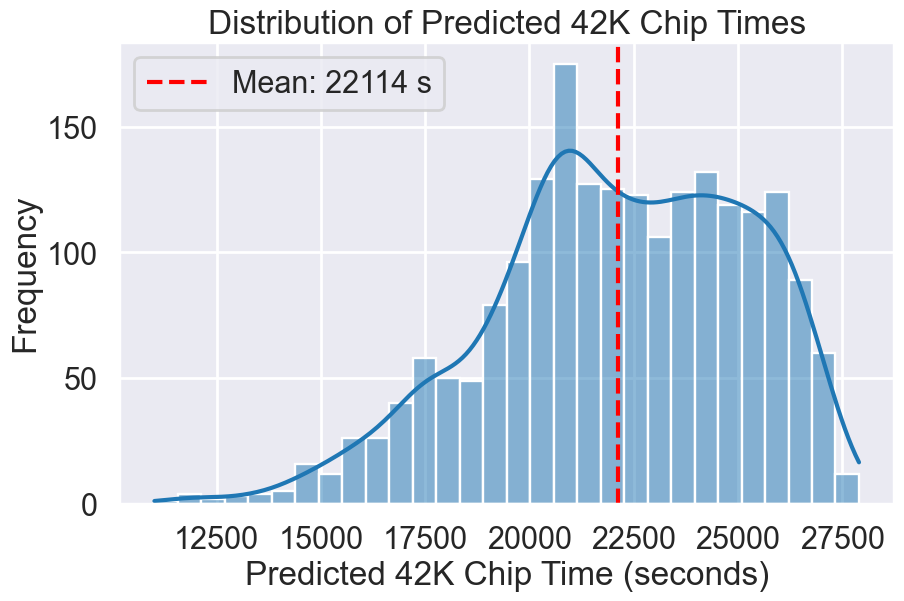

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

mean_time = np.mean(pred_42k)

plt.figure(figsize=(10, 6))
sns.histplot(pred_42k, bins=30, kde=True)
plt.axvline(mean_time, color='red', linestyle='--', label=f"Mean: {mean_time:.0f} s")
plt.xlabel("Predicted 42K Chip Time (seconds)")
plt.ylabel("Frequency")
plt.title("Distribution of Predicted 42K Chip Times")
plt.legend()
plt.show()


